In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, f1_score
import re

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback

from data_utils import DataUtils

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
MAX_SEQ_LEN = 256
BATCH_SIZE = 16
DS_SPLIT = 0.2
MIN_SPECIALITY_THRESHOLD = 100
DATASET_PATH = 'content/mtsamples.csv'
MODEL_NAME = 'nlpie/distil-biobert'

In [4]:
df = pd.read_csv(DATASET_PATH, usecols=['medical_specialty', 'transcription'])
df.head()

,medical_specialty,transcription
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...


In [5]:
utils = DataUtils()
df = utils.handle_nulls(df)
df = utils.handle_duplicates(df)

===== Null Summary =====
medical_specialty     0
transcription        33
dtype: int64
Dropping rows with missing values...
===== Duplicate Summary =====
Count: 2
Dropping duplicate rows...


===== Class Distribution =====
medical_specialty
Surgery                          1088
Consult - History and Phy.        516
Cardiovascular / Pulmonary        371
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  224
Neurology                         223
SOAP / Chart / Progress Notes     166
Urology                           156
Obstetrics / Gynecology           155
Discharge Summary                 108
Name: count, dtype: int64


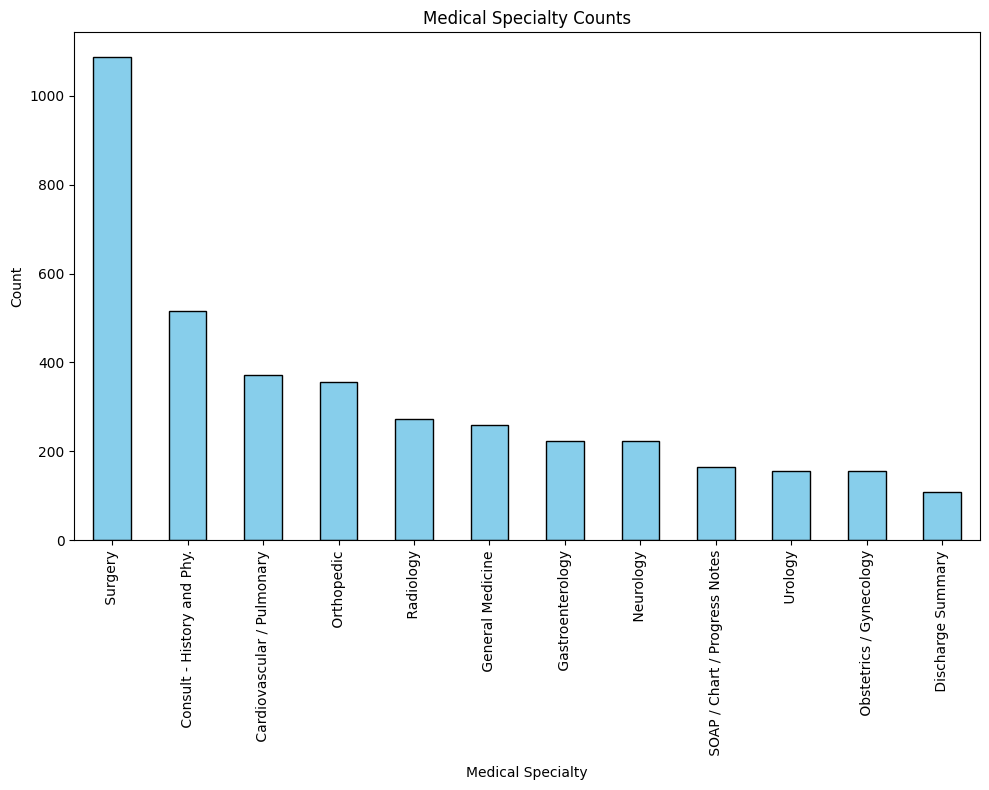

In [6]:
speciality_count = utils.class_distribution(df.medical_specialty, verbose=False)
filtered_df = df[df.medical_specialty.isin(speciality_count[speciality_count >= MIN_SPECIALITY_THRESHOLD].index)]
_ = utils.class_distribution(filtered_df.medical_specialty, 'Medical Specialty', show_plot=True)

In [7]:
def preprocess_text(text):
    text = utils.clean_text(text)
    return text

filtered_df['text'] = filtered_df['transcription'].map(preprocess_text)

In [8]:
filtered_df['class_id'] = pd.factorize(filtered_df.medical_specialty)[0]

print(f"Shape: {filtered_df.shape}")
print(f"Number of unique classes: {filtered_df.class_id.unique()}")

filtered_df.head()

Shape: (3894, 4)
Number of unique classes: [ 0  1  2  3  4  5  6  7  8  9 10 11]


,medical_specialty,transcription,text,class_id
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...",2 d m mode 1 left atrial enlargement with left...,0
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,1 the left ventricular cavity size and wall th...,0
7,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",2 d echocardiogram multiple views of the heart...,0
9,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size....",description 1 normal cardiac chambers size 2 n...,0
11,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc...",2 d study 1 mild aortic stenosis widely calcif...,0


In [9]:
ros = RandomOverSampler(random_state=42)
df_resampled, y_resampled = ros.fit_resample(
    filtered_df[['text']],
    filtered_df['class_id']
)

df_resampled['label'] = y_resampled
print(f"Resampled Shape: {df_resampled.shape}")

Resampled Shape: (13056, 2)


In [10]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokens = tokenizer(
    df_resampled['text'].tolist(),
    padding="max_length",
    truncation=True,
    max_length=MAX_SEQ_LEN,
    return_tensors="pt"
)

input_ids = tokens["input_ids"]
attention_mask = tokens["attention_mask"]
labels = torch.tensor(df_resampled["label"].values)

In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx],
        }

dataset = CustomDataset(input_ids, attention_mask, labels)
train_size = int((1 - DS_SPLIT) * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [16]:
codes, uniques = pd.factorize(filtered_df["medical_specialty"])

label2id = {label: idx for idx, label in enumerate(uniques)}
id2label = {idx: label for idx, label in enumerate(uniques)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(uniques),
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpie/distil-biobert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }

In [18]:
training_args = TrainingArguments(
    output_dir="./results",         
    load_best_model_at_end=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="f1_weighted",
    greater_is_better=True,
    learning_rate=2e-5,             
    per_device_train_batch_size=BATCH_SIZE, 
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=10,             
    weight_decay=0.01,
    logging_dir=None,           
    logging_steps=-1
)

trainer = Trainer(
    model=model,       
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

  0%|          | 0/6530 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.9405221939086914, 'eval_accuracy': 0.6447166921898928, 'eval_f1_weighted': 0.6188181368355086, 'eval_runtime': 9.8566, 'eval_samples_per_second': 265.001, 'eval_steps_per_second': 16.639, 'epoch': 1.0}


  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.8035138249397278, 'eval_accuracy': 0.6860643185298622, 'eval_f1_weighted': 0.6582141047206431, 'eval_runtime': 10.229, 'eval_samples_per_second': 255.354, 'eval_steps_per_second': 16.033, 'epoch': 2.0}


  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.7507319450378418, 'eval_accuracy': 0.6872128637059725, 'eval_f1_weighted': 0.6666944923530239, 'eval_runtime': 9.792, 'eval_samples_per_second': 266.748, 'eval_steps_per_second': 16.748, 'epoch': 3.0}


  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.7440209984779358, 'eval_accuracy': 0.69104134762634, 'eval_f1_weighted': 0.6669382738540875, 'eval_runtime': 9.8898, 'eval_samples_per_second': 264.111, 'eval_steps_per_second': 16.583, 'epoch': 4.0}


  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.7421678304672241, 'eval_accuracy': 0.6810872894333844, 'eval_f1_weighted': 0.6609143081933609, 'eval_runtime': 9.9188, 'eval_samples_per_second': 263.339, 'eval_steps_per_second': 16.534, 'epoch': 5.0}


  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.7143182754516602, 'eval_accuracy': 0.6849157733537519, 'eval_f1_weighted': 0.6671734824461586, 'eval_runtime': 9.8631, 'eval_samples_per_second': 264.825, 'eval_steps_per_second': 16.628, 'epoch': 6.0}


  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.7267940044403076, 'eval_accuracy': 0.6914241960183767, 'eval_f1_weighted': 0.6691475558505136, 'eval_runtime': 9.998, 'eval_samples_per_second': 261.253, 'eval_steps_per_second': 16.403, 'epoch': 7.0}


  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.7153602242469788, 'eval_accuracy': 0.6772588055130169, 'eval_f1_weighted': 0.6573923350173208, 'eval_runtime': 9.961, 'eval_samples_per_second': 262.223, 'eval_steps_per_second': 16.464, 'epoch': 8.0}


  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.713542640209198, 'eval_accuracy': 0.6830015313935681, 'eval_f1_weighted': 0.6642425115366162, 'eval_runtime': 10.1267, 'eval_samples_per_second': 257.932, 'eval_steps_per_second': 16.195, 'epoch': 9.0}
{'loss': 0.7268, 'grad_norm': 12.121818542480469, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.7196143269538879, 'eval_accuracy': 0.6898928024502297, 'eval_f1_weighted': 0.6690958030076926, 'eval_runtime': 9.7757, 'eval_samples_per_second': 267.193, 'eval_steps_per_second': 16.776, 'epoch': 10.0}
{'train_runtime': 1312.2325, 'train_samples_per_second': 79.59, 'train_steps_per_second': 4.976, 'train_loss': 0.7268482903426493, 'epoch': 10.0}


TrainOutput(global_step=6530, training_loss=0.7268482903426493, metrics={'train_runtime': 1312.2325, 'train_samples_per_second': 79.59, 'train_steps_per_second': 4.976, 'total_flos': 6918681186385920.0, 'train_loss': 0.7268482903426493, 'epoch': 10.0})

In [19]:
torch.save(model, "models/distilbiobert_med.pth")